## Setup

In [12]:
import re
import string
from collections import Counter

import pycountry
import pandas as pd
import numpy as np
import seaborn as sns
import country_converter as coco
import geopandas as gpd
from scipy.stats import zscore
from matplotlib import pyplot as plt
from matplotlib import rcParams
from matplotlib.axes import Axes
from matplotlib.gridspec import GridSpec
from matplotlib.colors import LogNorm
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from scipy.stats import pearsonr, normaltest
from adjustText import adjust_text
from statannotations.Annotator import Annotator
from itables import init_notebook_mode

from data_loaders import get_un_data, get_field_data, get_bibliometrics_data
from data_helpers import assign_industries, gini
from plot_helpers import index_subplots, plot_reg

sns.set_theme(context="paper", style="ticks", font="Arial", font_scale=1.0)
cc = coco.CountryConverter()
init_notebook_mode(all_interactive=True)

<IPython.core.display.Javascript object>

### Load Data

In [13]:
# UN Data
df_un = get_un_data()

# Publication counts for the entire fields
df_chem_all = get_field_data("chemistry")
df_bio_all = get_field_data("biology")

# Load the detailed data for ML publications
df_chem = get_bibliometrics_data("chemistry")
df_chem_pubs = df_chem.drop_duplicates(subset=["doi"])
df_chem_industry = assign_industries(df_chem)

df_bio = get_bibliometrics_data("biology")
df_bio_pubs = df_bio.drop_duplicates(subset=["doi"])
df_bio_industry = assign_industries(df_bio)

# Only keep one per country
df_chem = df_chem.drop_duplicates(subset=["doi", "country", "year"])

df_chem = df_chem[["doi", "country", "year"]].groupby(["doi", "country", "year"])
df_chem = df_chem.size().reset_index().drop(columns=[0]).groupby(["country", "year"]).size().reset_index()
df_chem = df_chem.rename(columns={0: "count"})

df_bio = df_bio.drop_duplicates(subset=["doi", "country", "year"])

df_bio = df_bio[["doi", "country", "year"]].groupby(["doi", "country", "year"])
df_bio = df_bio.size().reset_index().drop(columns=[0]).groupby(["country", "year"]).size().reset_index()
df_bio = df_bio.rename(columns={0: "count"})

print(len(df_bio_pubs), len(df_chem_pubs))

27861 16301


### Plots

#### Fraction of Publications (Yearly)

In [14]:
# Chemistry
df_chem_all_year = df_chem_all[["year", "count"]].groupby("year").sum().reset_index()

df_chem_ai_year = df_chem_pubs[["year"]].groupby("year").size().reset_index()
df_chem_ai_year = df_chem_ai_year[df_chem_ai_year.year >= 2000]
df_chem_ai_year = df_chem_ai_year.rename(columns={0: "count"})

df_chem_frac = df_chem_all_year.set_index("year").join(df_chem_ai_year.set_index("year"), rsuffix="_ai").reset_index()
df_chem_frac["frac"] = df_chem_frac["count_ai"] / df_chem_frac["count"] * 100
df_chem_frac["field"] = "Chemistry"

# Biology
df_bio_all_year = df_bio_all[["year", "count"]].groupby("year").sum().reset_index()

df_bio_ai_year = df_bio_pubs[["year"]].groupby("year").size().reset_index()
df_bio_ai_year = df_bio_ai_year[df_bio_ai_year.year >= 2000]
df_bio_ai_year = df_bio_ai_year.rename(columns={0: "count"})

df_bio_frac = df_bio_all_year.set_index("year").join(df_bio_ai_year.set_index("year"), rsuffix="_ai").reset_index()
df_bio_frac["frac"] = df_bio_frac["count_ai"] / df_bio_frac["count"] * 100
df_bio_frac["field"] = "Biology"

df_frac = pd.concat([df_chem_frac, df_bio_frac]).reset_index()

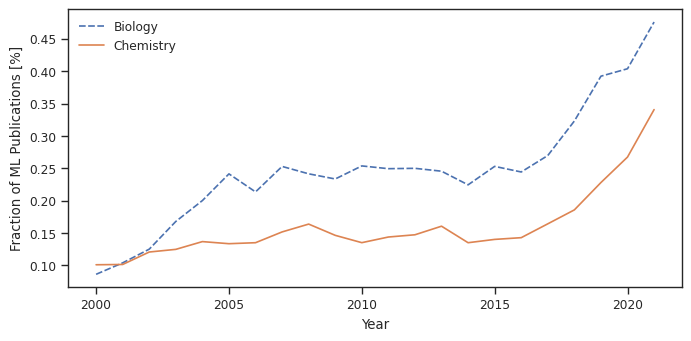

In [15]:
fig = plt.figure(facecolor="white", figsize=(2.0 * 3.5039, 3.5039))

ax = sns.lineplot(
    data=df_frac[df_frac.year >= 2000], 
    x="year", y="frac", 
    hue="field", hue_order=["Biology", "Chemistry"],
    style="field",
)
ax.set_ylabel("Fraction of ML Publications [%]")
ax.set_xlabel("Year")
ax.legend(title=None, frameon=False)
plt.tight_layout()
plt.savefig(f"total_frac.svg")
plt.savefig(f"total_frac.eps")

#### Fraction of Chemistry Publications (by Country)

Bio mean 0.2165346083309165 0.4096912510928915
Chem mean 0.20445452743109607 0.29351468548193727
Bio gini frac 0.28715383719683457 0.29212637670836467
Chem gini frac 0.34300908269491603 0.3039469235489793
Bio gini spending 0.4522716784819301 0.47940129122988434
Chem gini spending 0.49694561948522403 0.4889514318024788


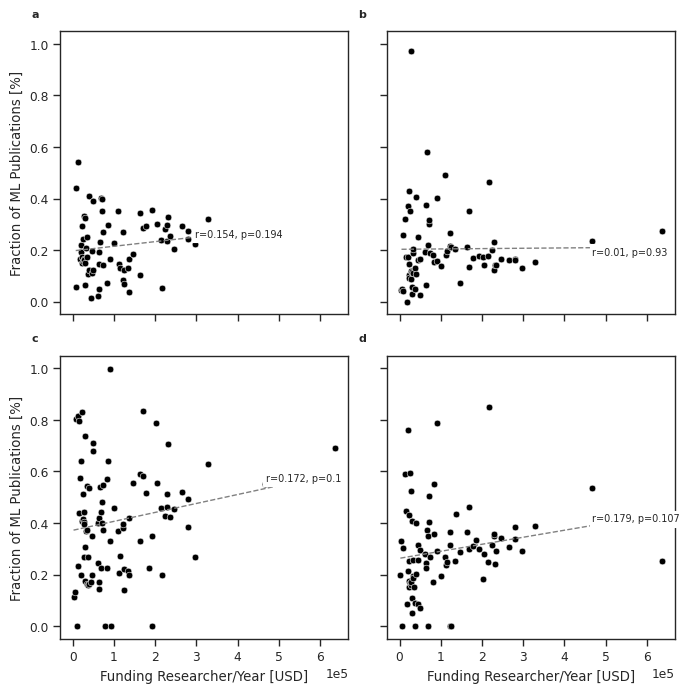

In [17]:
fig, axs = plt.subplots(2, 2, facecolor="white", figsize=(2.0 * 3.5039, 2.0 * 3.5039), sharex=True, sharey=True)

def get_frac_upto(df_spec, df_all, year_start = 2000, year_end = 2022):
    year_range = year_end - year_start + 1
    df_all_country = df_all[(df_all.year <= year_end) & (df_all.year >= year_start)][["country", "count"]].groupby(["country"]).sum().reset_index()
    df_spec_country = df_spec[(df_spec.year <= year_end) & (df_spec.year >= year_start) & (df_spec.country != "Unknown")][["country", "count"]].groupby("country").sum().reset_index()

    df_frac = df_all_country.set_index("country").join(df_spec_country.set_index("country"), lsuffix="_chem", rsuffix="_ai_chem").reset_index()
    df_frac["frac"] = df_frac["count_ai_chem"] / df_frac["count_chem"] * 100
    df_frac.fillna(0, inplace=True)

    df_frac = df_frac.set_index("country").join(df_un.set_index("country")).reset_index().dropna()

    # Shorten country names
    df_frac["country"] = cc.convert(
        names=df_frac.country, 
        to="ISO2", not_found="?"
    )
    
    df_frac = df_frac[np.abs(zscore(df_frac.frac)) < 3]
    # df_frac = df_frac[np.abs(zscore(df_frac.spending_per_researcher)) < 3]
    df_frac = df_frac[df_frac.population > 1000]
    df_frac = df_frac[df_frac.count_chem / year_range >= 100]
    df_frac = df_frac.sort_values(by="spending_per_researcher")

    df_frac["continent"] = cc.convert(names = df_frac.country, src = "ISO2", to = "continent")

    return df_frac




df_frac_bio = get_frac_upto(df_bio, df_bio_all, 2000, 2016)
df_frac_chem = get_frac_upto(df_chem, df_chem_all, 2000, 2016)

df_frac_bio_5 = get_frac_upto(df_bio, df_bio_all, 2017, 2021)
df_frac_chem_5 = get_frac_upto(df_chem, df_chem_all, 2017, 2021)

for i, df_frac in enumerate([df_frac_bio, df_frac_chem, df_frac_bio_5, df_frac_chem_5]):
    ax = axs.flat[i]
    sns.scatterplot(data=df_frac, x="spending_per_researcher", y="frac", color="black", ax=ax)
    ax.ticklabel_format(style="sci", axis="x", scilimits=(0,0))
    ax.set_ylabel("Fraction of ML Publications [%]")
    ax.set_xlabel("Funding Researcher/Year [USD]")
    plot_reg(df_frac.spending_per_researcher, df_frac.frac, ax)


index_subplots(axs.flat, font_size=8, y=1.05)
plt.tight_layout()
plt.savefig("figure_frac.svg")
plt.savefig("figure_frac.eps")

print("Bio mean", df_frac_bio["frac"].mean(), df_frac_bio_5["frac"].mean())
print("Chem mean", df_frac_chem["frac"].mean(), df_frac_chem_5["frac"].mean())

print("Bio gini frac", gini(df_frac_bio["frac"].to_numpy()), gini(df_frac_bio_5["frac"].to_numpy()))
print("Chem gini frac", gini(df_frac_chem["frac"].to_numpy()), gini(df_frac_chem_5["frac"].to_numpy()))

print("Bio gini spending", gini(df_frac_bio["spending_per_researcher"].to_numpy()), gini(df_frac_bio_5["spending_per_researcher"].to_numpy()))
print("Chem gini spending", gini(df_frac_chem["spending_per_researcher"].to_numpy()), gini(df_frac_chem_5["spending_per_researcher"].to_numpy()))

#### The Role of Industry

Chem None: 2.9919516508997206
Chem Pharma: 4.477164937747513
Chem Chem: 3.955027338906054
Chem Tech: 8.709876344037836
Chem Other: 3.614231935943429
Bio None: 3.030456751223146
Bio Pharma: 6.456416387167235
Bio Chem: 3.061510585897385
Bio Tech: 21.644731494850937
Bio Other: 4.126727966976383


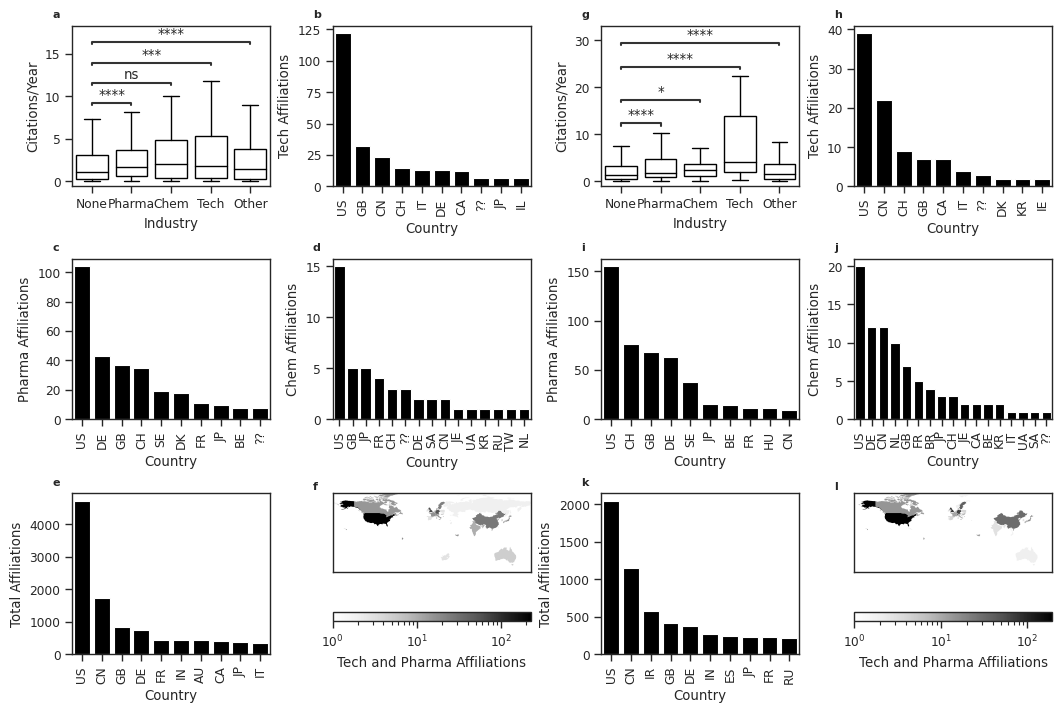

In [18]:
fig = plt.figure(facecolor="white", figsize=(3.0 * 3.5039, 2.0 * 3.5039), constrained_layout=True)
gs = GridSpec(3, 4, figure=fig)
ax0 = fig.add_subplot(gs[0, 0])
ax1 = fig.add_subplot(gs[0, 1])
ax2 = fig.add_subplot(gs[1, 0])
ax3 = fig.add_subplot(gs[1, 1])
ax4 = fig.add_subplot(gs[2, 0])
ax5 = fig.add_subplot(gs[2, 1])
ax6 = fig.add_subplot(gs[0, 2])
ax7 = fig.add_subplot(gs[0, 3])
ax8 = fig.add_subplot(gs[1, 2])
ax9 = fig.add_subplot(gs[1, 3])
ax10 = fig.add_subplot(gs[2, 2])
ax11 = fig.add_subplot(gs[2, 3])


def plot_industry(df_specific, axes):
    ##
    # Boxplot
    ##

    order = ["None", "Pharma", "Chem", "Tech", "Other"]
    sns.boxplot(
        data=df_specific[df_specific.age > 1], 
        x="type", y="citations_per_year", 
        order=order, showfliers=False, 
        color="white", linewidth=1,
        medianprops=dict(color="black"),
        boxprops=dict(edgecolor="black"),
        whiskerprops=dict(color="black"),
        capprops=dict(color="black"),
        ax=axes[0]
    )
    axes[0].set_ylabel("Citations/Year")
    axes[0].set_xlabel("Industry")
    pairs=[("None", "Tech"), ("None", "Pharma"), ("None", "Chem"), ("None", "Other")]

    annotator = Annotator(axes[0], pairs, data=df_specific[df_specific.age > 1], x="type", y="citations_per_year", order=order)
    annotator.configure(test="Mann-Whitney", text_format="star", verbose=False)
    annotator.apply_and_annotate()

    ##
    # Countplot Tech
    ##

    df_industry_exploded = df_specific.explode(["country"])
    df_industry_exploded = df_industry_exploded[df_industry_exploded.country != "Unknown"]
    df_industry_only_exploded = df_industry_exploded[df_industry_exploded.industry == 1]

    sns.countplot(
        data=df_industry_only_exploded[df_industry_only_exploded.type == "Tech"], 
        x="country", color="black",
        order=df_industry_only_exploded[df_industry_only_exploded.type == "Tech"].country.value_counts().iloc[:10].index,
        ax=axes[1]
    )
    axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=90, ha="center")
    axes[1].set_xlabel("Country")
    axes[1].set_ylabel("Tech Affiliations")

    ##
    # Countplot Pharma
    ##

    sns.countplot(
        data=df_industry_only_exploded[df_industry_only_exploded.type == "Pharma"], 
        x="country", color="black",
        order=df_industry_only_exploded[df_industry_only_exploded.type == "Pharma"].country.value_counts().iloc[:10].index,
        ax=axes[2]
    )
    axes[2].set_xticklabels(axes[2].get_xticklabels(), rotation=90, ha="center")
    axes[2].set_xlabel("Country")
    axes[2].set_ylabel("Pharma Affiliations")

    ##
    # Countplot Chem
    ##

    sns.countplot(
        data=df_industry_only_exploded[df_industry_only_exploded.type == "Chem"], 
        x="country", color="black",
        order=df_industry_only_exploded[df_industry_only_exploded.type == "Chem"].country.value_counts().index,
        ax=axes[3]
    )
    axes[3].set_xticklabels(axes[3].get_xticklabels(), rotation=90, ha="center")
    axes[3].set_xlabel("Country")
    axes[3].set_ylabel("Chem Affiliations")

    ##
    # Countplot All
    ##
    sns.countplot(
        data=df_industry_only_exploded, 
        x="country", color="black",
        order=df_industry_only_exploded.country.value_counts().iloc[:10].index,
        ax=axes[4]
    )
    axes[4].set_xticklabels(axes[4].get_xticklabels(), rotation=90, ha="center")
    axes[4].set_xlabel("Country")
    axes[4].set_ylabel("Total Affiliations")

    world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
    world["iso_a2"] = cc.convert(names=world["iso_a3"], to="ISO2", not_found="??")
    world = world[(world.pop_est > 0) & (world.name != "Antarctica")]

    df_country_count = df_industry_only_exploded[
        (df_industry_only_exploded.type == "Pharma") | (df_industry_only_exploded.type == "Tech")
    ].groupby("country").size().reset_index().rename(columns={0: "affiliations"})

    world = world.set_index("iso_a2").join(df_country_count.set_index("country")).fillna(0)

    norm = LogNorm(vmin=1, vmax=world.affiliations.max())

    world.plot(
        column="affiliations", cmap="Greys", 
        legend=True, norm=norm, linewidth=0, 
        ax=axes[5], legend_kwds={"orientation": "horizontal", "pad": -0.55, "label": "Tech and Pharma Affiliations"}
    )
    axes[5].margins(0)
    axes[5].tick_params(left=False, labelleft=False, bottom=False, labelbottom=False)
    axes[5].set_anchor("NW")

    
    # plt.tight_layout()

plot_industry(df_bio_industry, [ax0, ax1, ax2, ax3, ax4, ax5])
plot_industry(df_chem_industry, [ax6, ax7, ax8, ax9, ax10, ax11])

index_subplots([ax0, ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8, ax9, ax10, ax11], font_size=8, y=1.05)
plt.savefig("figure_ai_collabs.svg")
plt.savefig("figure_ai_collabs.eps")

print("Chem None:", df_chem_industry[df_chem_industry["type"] == "None"]["citations_per_year"].mean())
print("Chem Pharma:", df_chem_industry[df_chem_industry["type"] == "Pharma"]["citations_per_year"].mean())
print("Chem Chem:", df_chem_industry[df_chem_industry["type"] == "Chem"]["citations_per_year"].mean())
print("Chem Tech:", df_chem_industry[df_chem_industry["type"] == "Tech"]["citations_per_year"].mean())
print("Chem Other:", df_chem_industry[df_chem_industry["type"] == "Other"]["citations_per_year"].mean())

print("Bio None:", df_bio_industry[df_bio_industry["type"] == "None"]["citations_per_year"].mean())
print("Bio Pharma:", df_bio_industry[df_bio_industry["type"] == "Pharma"]["citations_per_year"].mean())
print("Bio Chem:", df_bio_industry[df_bio_industry["type"] == "Chem"]["citations_per_year"].mean())
print("Bio Tech:", df_bio_industry[df_bio_industry["type"] == "Tech"]["citations_per_year"].mean())
print("Bio Other:", df_bio_industry[df_bio_industry["type"] == "Other"]["citations_per_year"].mean())

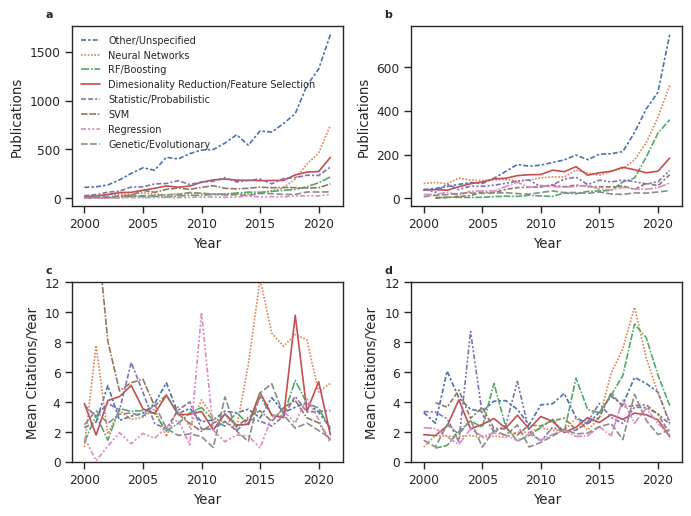

In [19]:
fig, axs = plt.subplots(2, 2, facecolor="white", figsize=(2.0 * 3.5039, 1.5 * 3.5039))
axs = axs.flat

df_tmp = df_bio_industry.copy()
df_tmp["count"] = 1
df_tmp = df_tmp[(df_tmp.year >= 2000)].groupby(["year", "method"]).agg({"count": "sum", "citations": "sum", "citations_per_year": "mean"}).reset_index()

sns.lineplot(
    data=df_tmp, 
    x="year", y="count",
    style="method",
    hue="method",
    hue_order=["Other/Unspecified", "Neural Networks", "RF/Boosting", "Dimesionality Reduction/Feature Selection", "Statistic/Probabilistic", "SVM", "Regression", "Genetic/Evolutionary"],
    ax=axs[0]
)

axs[0].set_ylabel("Publications")
axs[0].set_xlabel("Year")
axs[0].legend(title=None, frameon=False, fontsize=7)

sns.lineplot(
    data=df_tmp, 
    x="year", y="citations_per_year",
    style="method",
    hue="method",
    hue_order=["Other/Unspecified", "Neural Networks", "RF/Boosting", "Dimesionality Reduction/Feature Selection", "Statistic/Probabilistic", "SVM", "Regression", "Genetic/Evolutionary"],
    ax=axs[2]
)

axs[2].set_ylim([0, 12])
axs[2].set_ylabel("Mean Citations/Year")
axs[2].set_xlabel("Year")
axs[2].get_legend().remove()


df_tmp = df_chem_industry.copy()
df_tmp["count"] = 1
df_tmp = df_tmp[(df_tmp.year >= 2000)].groupby(["year", "method"]).agg({"count": "sum", "citations": "sum", "citations_per_year": "mean"}).reset_index()

df_tmp["frac"] = df_tmp["count"] / df_tmp.groupby("year")["count"].transform("sum") * 100


sns.lineplot(
    data=df_tmp, 
    x="year", y="count",
    style="method",
    hue="method",
    hue_order=["Other/Unspecified", "Neural Networks", "RF/Boosting", "Dimesionality Reduction/Feature Selection", "Statistic/Probabilistic", "SVM", "Regression", "Genetic/Evolutionary"],
    ax=axs[1]
)

axs[1].set_ylabel("Publications")
axs[1].set_xlabel("Year")
axs[1].get_legend().remove()

sns.lineplot(
    data=df_tmp, 
    x="year", y="citations_per_year",
    style="method",
    hue="method",
    hue_order=["Other/Unspecified", "Neural Networks", "RF/Boosting", "Dimesionality Reduction/Feature Selection", "Statistic/Probabilistic", "SVM", "Regression", "Genetic/Evolutionary"],
    ax=axs[3]
)

axs[3].set_ylim([0, 12])
axs[3].set_ylabel("Mean Citations/Year")
axs[3].set_xlabel("Year")
axs[3].get_legend().remove()

index_subplots(axs, font_size=8, y=1.05)
plt.tight_layout()

plt.savefig("figure_methods.svg")
plt.savefig("figure_methods.eps")
